# Analysis of order of contigs with QUAST

In order to analyse whether the plasmid sequences produced by HyAsP correspond to the expected plasmids or whether misassembly events happened, we compared the sequences using QUAST.

*Summary:*   
HyAsP's predictions included misassemblies in a lot of test samples.
Relocations were the predominant misassembly type, followed by translocations and only a few inversions.
There was no clear correlation between the number of frequency of misassembly events and the prediction scores.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

pd.options.display.max_rows = None

In [3]:
proj_dir = '/project/6007976/wg-anoph/Plasmids-Assembly'
ids_file = '%s/data/2018-10-29__databases_greedy_paper/mob_database_filtered/test_ids.txt' % proj_dir

with open(ids_file, 'r') as in_file:
    ids = [int(line.strip()) for line in in_file]

*Read misassembly statistics*

In [4]:
col_id = []
col_tool = []
value_lists = [[], [], [], [], [], [], [], [], [], [], [], [], []]
missing = dict()

for sid in ids:
    col_id.append(sid)
    col_tool.append('greedy')

    file = '%s/exp/2018-10-29__analyses_greedy_paper/quast_results_mob_filtered/%i_quast/contigs_reports/misassemblies_report.tsv' % (proj_dir, sid)
    with open(file, 'r') as in_file:
        non_empty = in_file.readline().strip().split('\t')[1:]
        if 'greedy' in non_empty:
            for i, line in enumerate(in_file.readlines()):
                value_lists[i].append(int(line.strip().split('\t')[1]))
            missing[sid] = False
        
        else:
            for i in range(0, 13):
                value_lists[i].append(0)
            missing[sid] = True
    
col_misasm = value_lists[0] # entry '# misassemblies'
col_relocations = value_lists[1] # entry '# relocations'
col_translocations = value_lists[2] # entry '# translocations'
col_inversions = value_lists[3] # entry '# inversions'
col_misasm_contigs = value_lists[4] # entry '# misassembled contigs'
col_misasm_contigs_len = value_lists[5] # entry 'Misassembled contigs length'
col_local_misasm = value_lists[6] # entry '# local misassemblies'
col_unaligned_misasm_contigs = value_lists[7] # entry '# unaligned mis. contigs'
col_mismatches = value_lists[8] # entry '# mismatches'
col_indels = value_lists[9] # entry '# indels'
col_indels_small = value_lists[10] # entry '# indels (<= 5 bp)'
col_indels_large = value_lists[11] # entry '# indels (> 5 bp)'
col_indels_length = value_lists[12] # entry 'Indels length'

cols = ['sample', 'tool', 'num_misassemblies', 'num_relocations', 'num_translocations', 'num_inversions', 'num_misassembled_contigs',
        'len_misassembled_contigs', 'num_local_misassemblies', 'num_unaligned_misassembled_contigs', 'num_mismatches',
        'num_indels', 'num_small_indels', 'num_large_indels', 'len_indels']

stats = pd.DataFrame({cols[0]: col_id, cols[1]: col_tool, cols[2]: col_misasm, cols[3]: col_relocations, cols[4]: col_translocations,
                      cols[5]: col_inversions, cols[6]: col_misasm_contigs, cols[7]: col_misasm_contigs_len, cols[8]: col_local_misasm,
                      cols[9]: col_unaligned_misasm_contigs, cols[10]: col_mismatches, cols[11]: col_indels, cols[12]: col_indels_small,
                      cols[13]: col_indels_large, cols[14]: col_indels_length}, columns = cols)

*Add total lengths of predicted and expected plasmids*

In [5]:
prediction_lengths = []
prediction_nums = []
reference_lengths = []
reference_nums = []

empty = dict()

for sid in ids:
    file = '%s/exp/2018-10-29__analyses_greedy_paper/analysis_mob_filtered/sample_%i/eval/greedy/greedy_eval.csv' % (proj_dir, sid)
    with open(file, 'r') as in_file:
        lines = in_file.readlines()
        
        num_chr_references = int(lines[1].strip().split(' ')[-1])
        num_pla_references = int(lines[2 + num_chr_references].strip().split(' ')[-1])
        len_sum = 0
        for i in range(0, num_pla_references):
            len_sum += int(lines[3 + num_chr_references + i].strip().split(' ')[-2])
        reference_lengths.append(len_sum)
        reference_nums.append(num_pla_references)
        
        num_predictions = int(lines[5 + num_chr_references + num_pla_references].strip().split(' ')[-1])
        len_sum = 0
        for i in range(0, num_predictions):
            len_sum += int(lines[6 + num_chr_references + num_pla_references + i].strip().split(' ')[-2])
        prediction_lengths.append(len_sum)
        prediction_nums.append(num_predictions)
        
    empty[sid] = (num_predictions == 0)        
        
stats['prediction_length'] = prediction_lengths
stats['reference_length'] = reference_lengths
stats['num_predictions'] = prediction_nums
stats['num_references'] = reference_nums

*Add precision, recall and F1 score*

In [6]:
scores = pd.read_csv('%s/exp/2018-10-29__analyses_greedy_paper/analysis_mob_filtered/scoring_results.csv' % proj_dir, sep = ';')

precisions = []
recalls = []
f1s = []
sample_groups = scores.groupby('sample_id')
for sid in ids:
    grp = sample_groups.get_group(sid)
    
    r = grp[grp['tool'] == 'greedy_putative']
    precisions.append(r['precision'].item() if len(r) > 0 else 0.0)
    recalls.append(r['recall'].item() if len(r) > 0 else 0.0)
    f1s.append(r['f1_score'].item() if len(r) > 0 else 0.0)
        
stats['precision'] = precisions
stats['recall'] = recalls
stats['f1_score'] = f1s

*Sort by sample id and extract statistics on greedy plasmids*

Subsequently, the analysis uses only the statistics of the plasmid sequences predicted by HyAsP. The statistics on the contigs underlying these sequences as well as the ones of plasmidSPAdes and MOB-recon are not informative because the unconcatenated contigs can be freely orientated by QUAST and, thus, show (almost) no misassembly events.

In [7]:
stats.sort_values(by = ['sample'], inplace = True)
stats.to_csv('hyasp_quast_stats_mob_filtered.csv', sep = ';', index = False)
greedy_stats = stats[stats['tool'] == 'greedy']

**Misassembly events per sample**

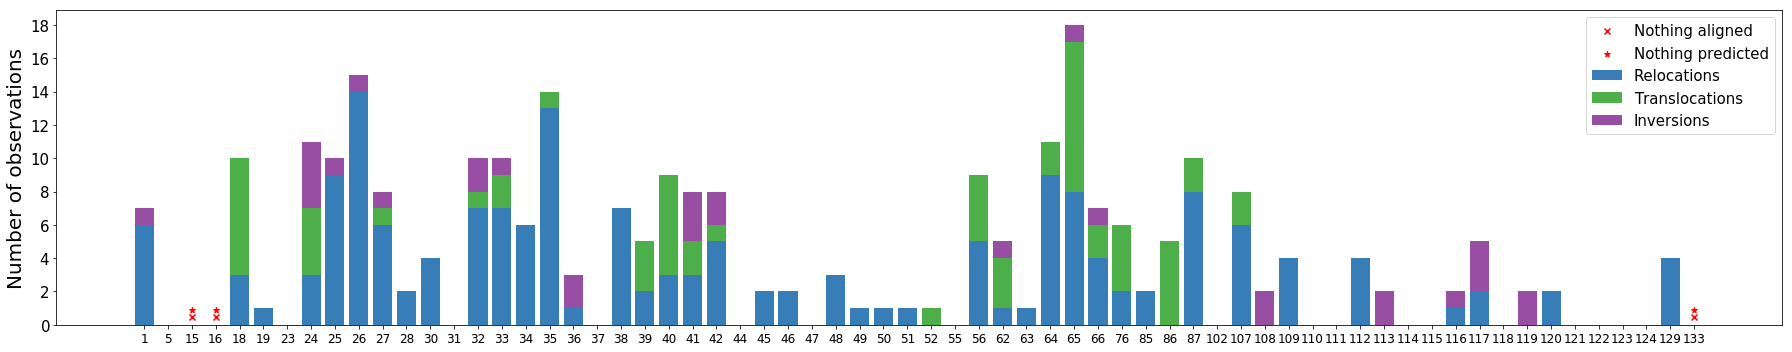

In [8]:
plt.figure(figsize = (25, 5))
pos = range(1, len(greedy_stats['num_misassemblies']) + 1)

rel_bar = greedy_stats['num_relocations']
trans_bar = greedy_stats['num_translocations']
inv_bar = greedy_stats['num_inversions']

pos_missing = []
pos_empty = []
for i, sid in enumerate(greedy_stats['sample']):
    if missing[sid]:
        pos_missing.append(i + 1)
    if empty[sid]:
        pos_empty.append(i + 1)

plt.bar(pos, rel_bar, color = '#377eb8', label = 'Relocations')
plt.bar(pos, trans_bar, bottom = rel_bar, color = '#4daf4a', label = 'Translocations')
plt.bar(pos, inv_bar, bottom = np.array(rel_bar) + np.array(trans_bar), color = '#984ea3', label = 'Inversions')

plt.scatter(pos_missing, [0.45] * len(pos_missing), marker = 'x', color = 'red', label = 'Nothing aligned')
plt.scatter(pos_empty, [0.9] * len(pos_empty), marker = '*', color = 'red', label = 'Nothing predicted')

plt.xticks(range(1, len(greedy_stats['num_misassemblies']) + 1), greedy_stats['sample'], fontsize = 12);
plt.yticks(range(0, max(greedy_stats['num_misassemblies']) + 2, 2), fontsize = 15);
plt.ylabel('Number of observations', fontsize = 20);
plt.legend(fontsize = 15)
plt.tight_layout()

plt.savefig('misassembly_counts_mob_filtered.eps', format = 'eps', dpi = 1200)
plt.savefig('misassembly_counts_mob_filtered.pdf', format = 'pdf', dpi = 1200)
#plt.savefig('misassembly_counts_mob_filtered.png', format = 'png', dpi = 1200)

**Average number of misassembly events in 1000 nt of predicted plasmids per sample**

/home/rmuller/py3.5.4/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/rmuller/py3.5.4/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/rmuller/py3.5.4/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/rmuller/py3.5.4/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


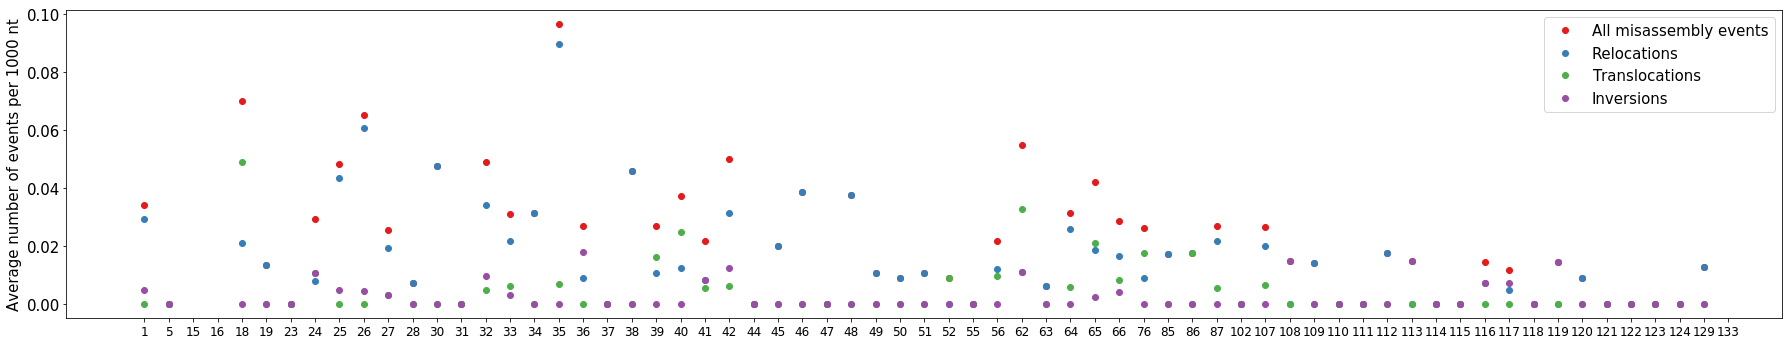

In [9]:
plt.figure(figsize = (25, 5))
pos = range(1, len(greedy_stats['num_misassemblies']) + 1)

plt.plot(pos, 1000 * np.array(greedy_stats['num_misassemblies']) / np.array(greedy_stats['prediction_length']), 'o', color = '#e41a1c')
plt.plot(pos, 1000 * np.array(greedy_stats['num_relocations']) / np.array(greedy_stats['prediction_length']), 'o', color = '#377eb8')
plt.plot(pos, 1000 * np.array(greedy_stats['num_translocations']) / np.array(greedy_stats['prediction_length']), 'o', color = '#4daf4a')
plt.plot(pos, 1000 * np.array(greedy_stats['num_inversions']) / np.array(greedy_stats['prediction_length']), 'o', color = '#984ea3')

plt.xticks(range(1, len(greedy_stats['num_misassemblies']) + 1), greedy_stats['sample'], fontsize = 12);
plt.yticks(fontsize = 15);
plt.ylabel('Average number of events per 1000 nt', fontsize = 15);
plt.legend(['All misassembly events', 'Relocations', 'Translocations', 'Inversions'], fontsize = 15)
plt.tight_layout()

plt.savefig('misassembly_rates_mob_filtered.eps', format = 'eps', dpi = 1200)
plt.savefig('misassembly_rates_mob_filtered.pdf', format = 'pdf', dpi = 1200)
#plt.savefig('misassembly_rates_mob_filtered.png', format = 'png', dpi = 1200)

Above RuntimeWarning is "intended" (affected positions, i.e. empty predictions, also remain empty in plot).

**Distributions of misassembly events**

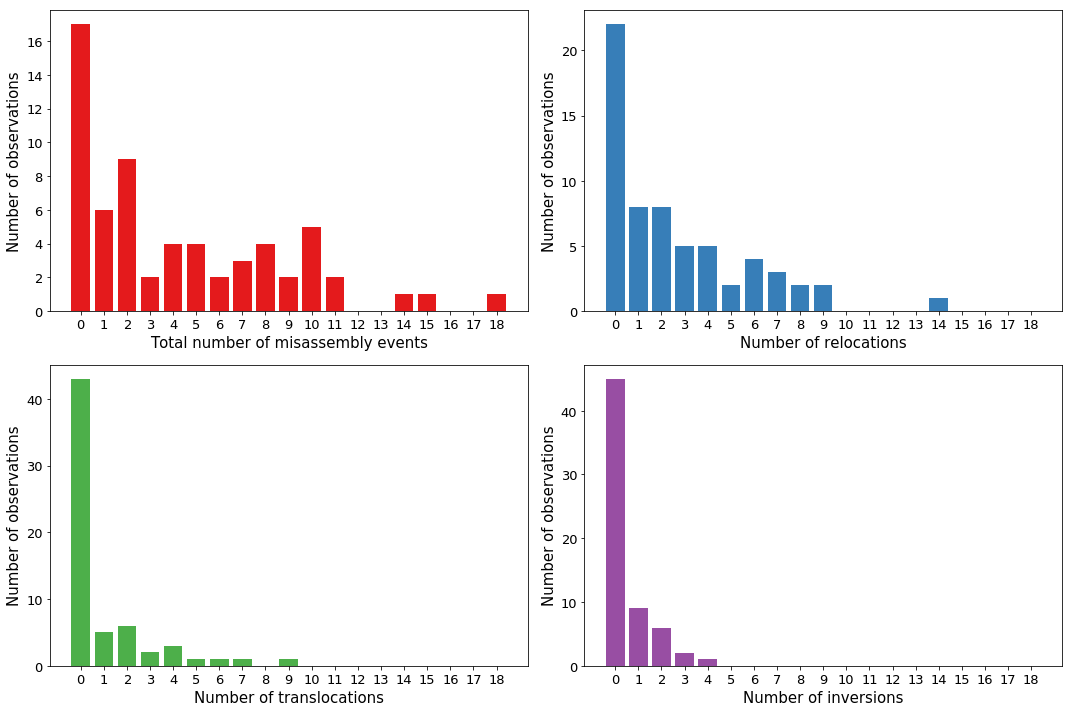

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
values = sorted(greedy_stats['num_misassemblies'].unique())

stats_non_empty = greedy_stats.loc[greedy_stats['num_predictions'] > 0]

axes[0, 0].bar(values, [len(stats_non_empty[stats_non_empty['num_misassemblies'] == n]) for n in values], color = '#e41a1c')
axes[0, 0].set_xlabel('Total number of misassembly events', fontsize = 15)

axes[0, 1].bar(values, [len(stats_non_empty[stats_non_empty['num_relocations'] == n]) for n in values], color = '#377eb8')
axes[0, 1].set_xlabel('Number of relocations', fontsize = 15)

axes[1, 0].bar(values, [len(stats_non_empty[stats_non_empty['num_translocations'] == n]) for n in values], color = '#4daf4a')
axes[1, 0].set_xlabel('Number of translocations', fontsize = 15)

axes[1, 1].bar(values, [len(stats_non_empty[stats_non_empty['num_inversions'] == n]) for n in values], color = '#984ea3')
axes[1, 1].set_xlabel('Number of inversions', fontsize = 15)

for i in range(0, 2):
    for j in range(0, 2):
        axes[i, j].set_ylabel('Number of observations', fontsize = 15)
        axes[i, j].set_xticks(range(values[0], values[-1] + 1))
        axes[i, j].tick_params(axis = 'x', labelsize = 13)
        axes[i, j].tick_params(axis = 'y', labelsize = 13)
plt.tight_layout()

plt.savefig('misassembly_hists_mob_filtered.eps', format = 'eps', dpi = 1200)
plt.savefig('misassembly_hists_mob_filtered.pdf', format = 'pdf', dpi = 1200)
#plt.savefig('misassembly_hists_mob_filtered.png', format = 'png', dpi = 1200)

**Misassembly events vs. scores**

*Counts vs. scores*

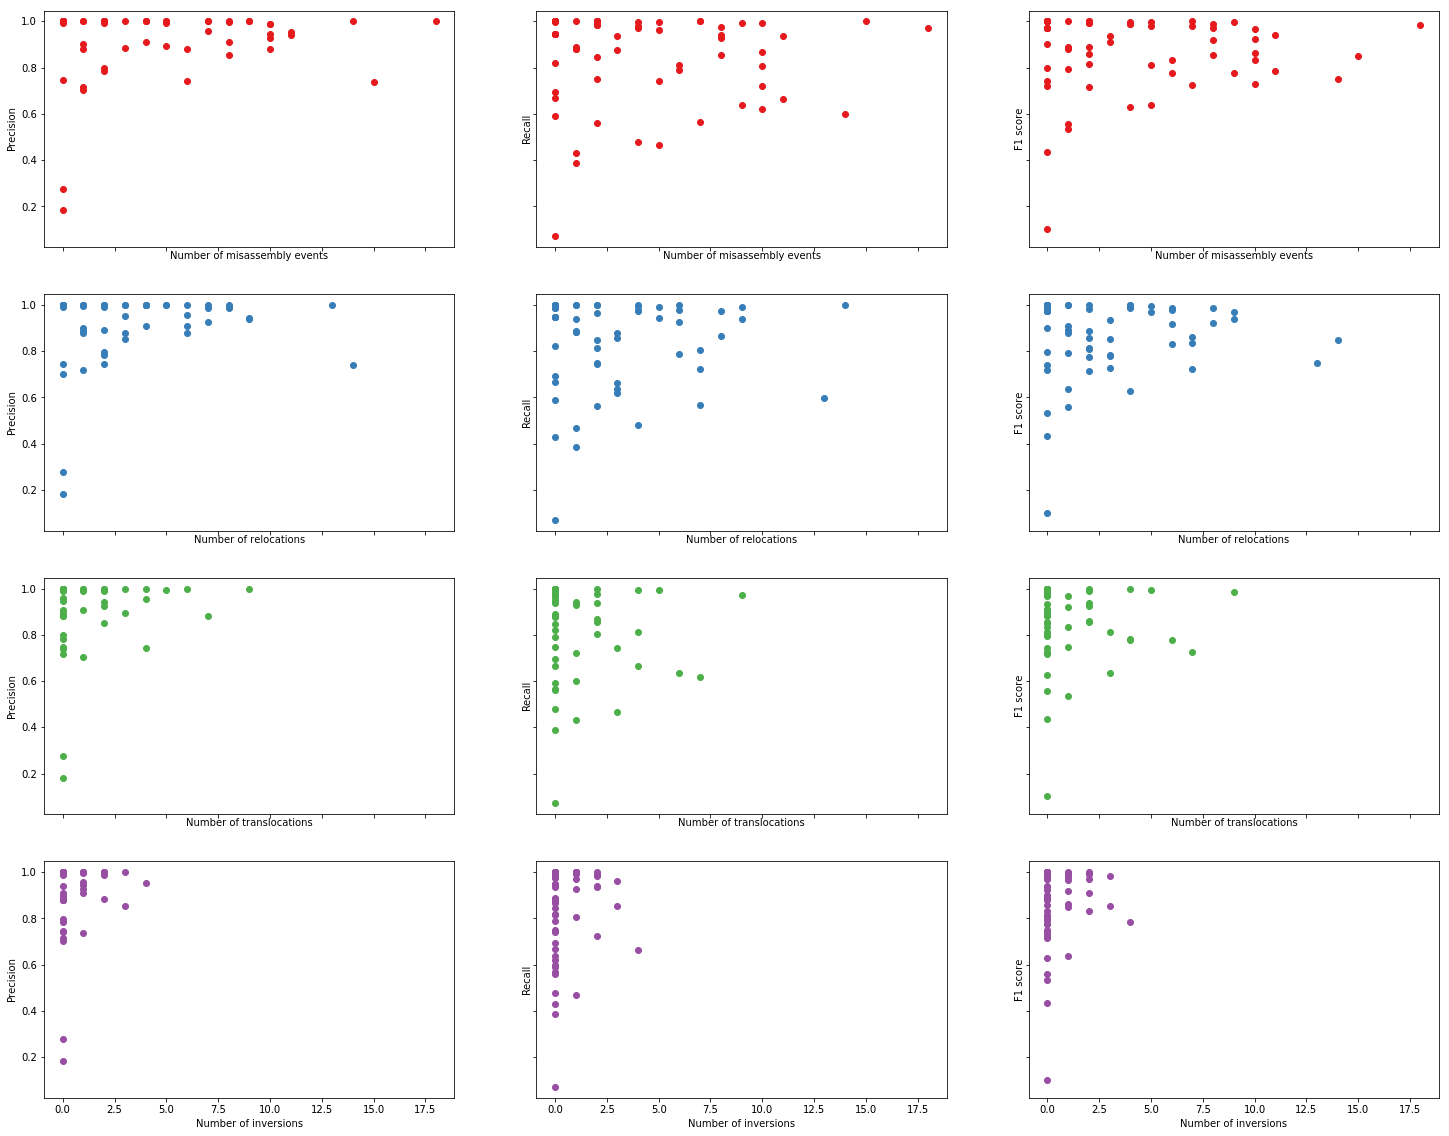

In [11]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (25, 20), sharex = True, sharey = True)

stats_non_empty = greedy_stats.loc[greedy_stats['num_predictions'] > 0]

axes[0, 0].plot(stats_non_empty['num_misassemblies'], stats_non_empty['precision'], 'o', color = '#e41a1c')
axes[0, 1].plot(stats_non_empty['num_misassemblies'], stats_non_empty['recall'], 'o', color = '#e41a1c')
axes[0, 2].plot(stats_non_empty['num_misassemblies'], stats_non_empty['f1_score'], 'o', color = '#e41a1c')

axes[1, 0].plot(stats_non_empty['num_relocations'], stats_non_empty['precision'], 'o', color = '#377eb8')
axes[1, 1].plot(stats_non_empty['num_relocations'], stats_non_empty['recall'], 'o', color = '#377eb8')
axes[1, 2].plot(stats_non_empty['num_relocations'], stats_non_empty['f1_score'], 'o', color = '#377eb8')

axes[2, 0].plot(stats_non_empty['num_translocations'], stats_non_empty['precision'], 'o', color = '#4daf4a')
axes[2, 1].plot(stats_non_empty['num_translocations'], stats_non_empty['recall'], 'o', color = '#4daf4a')
axes[2, 2].plot(stats_non_empty['num_translocations'], stats_non_empty['f1_score'], 'o', color = '#4daf4a')

axes[3, 0].plot(stats_non_empty['num_inversions'], stats_non_empty['precision'], 'o', color = '#984ea3')
axes[3, 1].plot(stats_non_empty['num_inversions'], stats_non_empty['recall'], 'o', color = '#984ea3')
axes[3, 2].plot(stats_non_empty['num_inversions'], stats_non_empty['f1_score'], 'o', color = '#984ea3')

xlabs = ['Number of misassembly events', 'Number of relocations', 'Number of translocations', 'Number of inversions']
ylabs = ['Precision', 'Recall', 'F1 score']
for i in range(0, 4):
    for j in range(0, 3):
        axes[i, j].set_xlabel(xlabs[i])
        axes[i, j].set_ylabel(ylabs[j])

plt.show()

*Rates vs. scores*

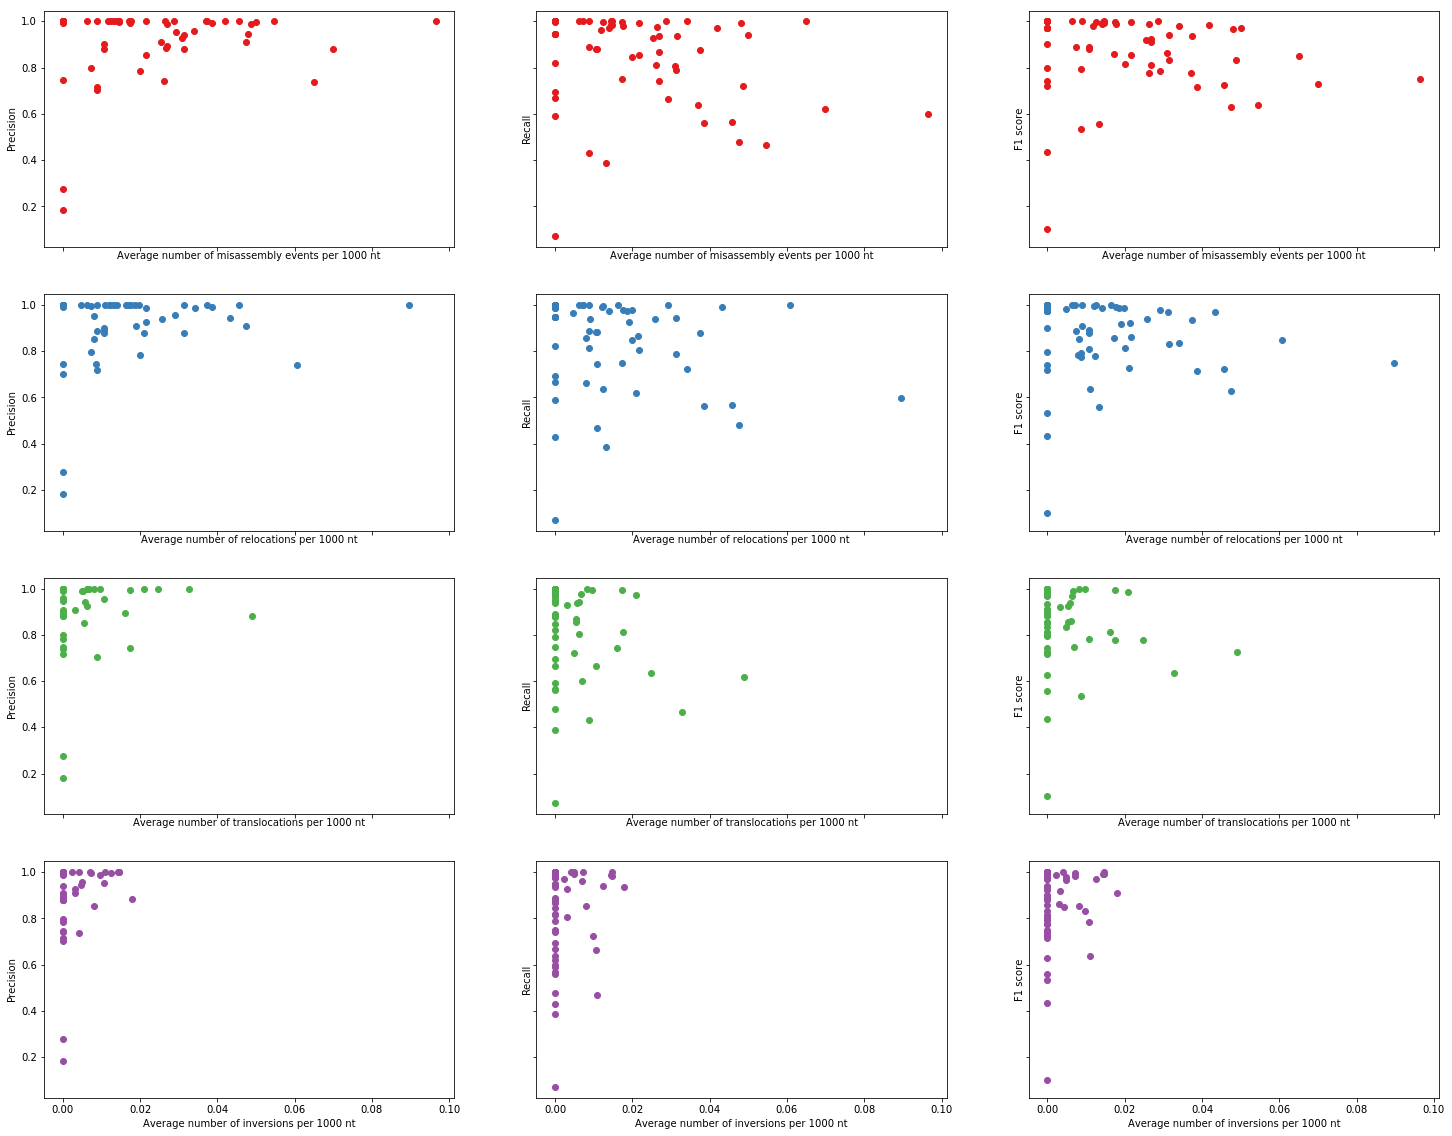

In [12]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (25, 20), sharex = True, sharey = True)

stats_non_empty = greedy_stats.loc[greedy_stats['num_predictions'] > 0]

misasm_rates = 1000 * np.array(stats_non_empty['num_misassemblies']) / np.array(stats_non_empty['prediction_length'])
rel_rates = 1000 * np.array(stats_non_empty['num_relocations']) / np.array(stats_non_empty['prediction_length'])
trans_rates = 1000 * np.array(stats_non_empty['num_translocations']) / np.array(stats_non_empty['prediction_length'])
inv_rates = 1000 * np.array(stats_non_empty['num_inversions']) / np.array(stats_non_empty['prediction_length'])

axes[0, 0].plot(misasm_rates, stats_non_empty['precision'], 'o', color = '#e41a1c')
axes[0, 1].plot(misasm_rates, stats_non_empty['recall'], 'o', color = '#e41a1c')
axes[0, 2].plot(misasm_rates, stats_non_empty['f1_score'], 'o', color = '#e41a1c')

axes[1, 0].plot(rel_rates, stats_non_empty['precision'], 'o', color = '#377eb8')
axes[1, 1].plot(rel_rates, stats_non_empty['recall'], 'o', color = '#377eb8')
axes[1, 2].plot(rel_rates, stats_non_empty['f1_score'], 'o', color = '#377eb8')

axes[2, 0].plot(trans_rates, stats_non_empty['precision'], 'o', color = '#4daf4a')
axes[2, 1].plot(trans_rates, stats_non_empty['recall'], 'o', color = '#4daf4a')
axes[2, 2].plot(trans_rates, stats_non_empty['f1_score'], 'o', color = '#4daf4a')

axes[3, 0].plot(inv_rates, stats_non_empty['precision'], 'o', color = '#984ea3')
axes[3, 1].plot(inv_rates, stats_non_empty['recall'], 'o', color = '#984ea3')
axes[3, 2].plot(inv_rates, stats_non_empty['f1_score'], 'o', color = '#984ea3')

xlabs = ['Average number of misassembly events per 1000 nt', 'Average number of relocations per 1000 nt', 
         'Average number of translocations per 1000 nt', 'Average number of inversions per 1000 nt']
ylabs = ['Precision', 'Recall', 'F1 score']
for i in range(0, 4):
    for j in range(0, 3):
        axes[i, j].set_xlabel(xlabs[i])
        axes[i, j].set_ylabel(ylabs[j])

plt.show()